# Gestión de carteras

# Importamos librerias

In [4]:
import math
import numpy as np
import scipy.stats as scs
import statsmodels.api as sm
import yfinance as yf
import pandas as pd
from pylab import mpl, plt

## Definimos las características de los gráficos 

In [5]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Recuperamos precios y calculamos rentabilidades 

In [6]:
symbols = ["MSFT","AAPL","GS","SPY"]
tickers = yf.Tickers(symbols) # [spy,gld,appl,msft]

In [7]:
data = tickers.history(start='2010-10-20',end='2012-10-20').Close.dropna()

[*********************100%***********************]  4 of 4 completed


<AxesSubplot:xlabel='Date'>

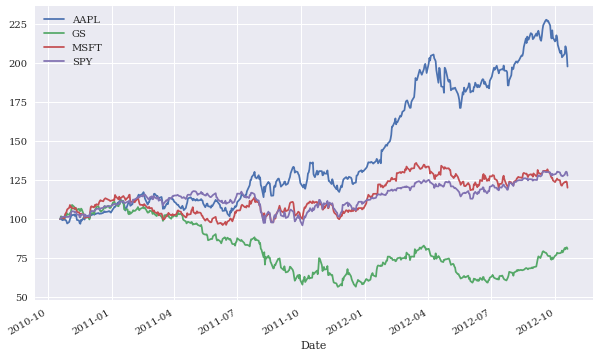

In [8]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'GS'}>],
       [<AxesSubplot:title={'center':'MSFT'}>,
        <AxesSubplot:title={'center':'SPY'}>]], dtype=object)

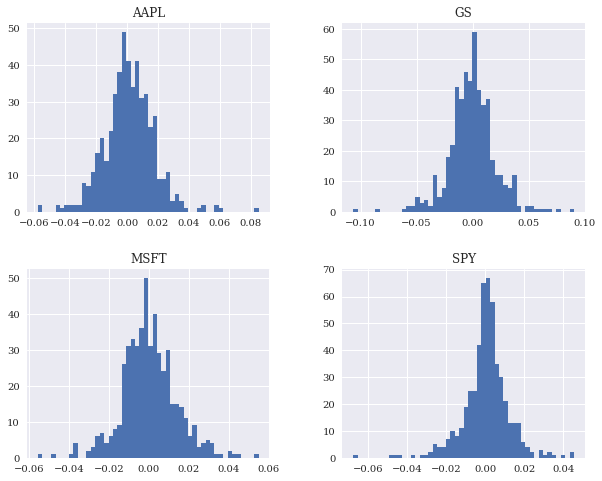

In [9]:
rets = np.log(data / data.shift(1))
rets.hist(bins=50, figsize=(10, 8))

## Creamos una cartera aleatoria con cuatro títulos 

Nos guardamos la cantidad de activos en una variable

In [10]:
noa = len(symbols)

Calculamos la media anualizada, en días laborables

In [11]:
rets.mean() * 252

AAPL    0.339929
GS     -0.105234
MSFT    0.091630
SPY     0.122801
dtype: float64

Covarianza entre activos anualizada

In [12]:
rets.cov() * 252

,AAPL,GS,MSFT,SPY
AAPL,0.065929,0.030387,0.025817,0.028745
GS,0.030387,0.110483,0.038814,0.046535
MSFT,0.025817,0.038814,0.047386,0.030431
SPY,0.028745,0.046535,0.030431,0.034287


Vamos a generar unos pesos random para la cartera

In [13]:
weights = np.random.random(noa)
print(weights)

[0.35361508 0.28753964 0.21313713 0.76710758]


Normalizamos los pesos, es decir que sumen 1

In [14]:
weights /= np.sum(weights)
print(weights)

[0.21809252 0.17734041 0.13145258 0.4731145 ]


Calculamos la rentabilidad de la cartera

In [15]:
np.dot(rets.mean().T *252, weights)   

0.12561783140791402

Calculamos la volatilidad de la cartera

In [16]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.03827055896269863

In [17]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.19562862511068935

Transformamos la rentabilidad y la volatilidad en una función

In [18]:
def port_ret(weights, rets):
    return np.dot(rets.mean().T *252, weights)

In [19]:
def port_vol(weights,rets):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

Creamos una función para los pesos

In [20]:
def pesos_aleatorios(noa):
    pesos = np.random.random(noa)
    pesos /= np.sum(pesos)
    return pesos

Generamos 2500 carteras aleatorias

In [21]:
prets = [] 
pvols = [] 

In [22]:
for p in range (2500):
    weights = pesos_aleatorios(noa)
    prets.append(port_ret(weights,rets=rets))
    pvols.append(port_vol(weights,rets=rets))

In [23]:
prets = np.array(prets) 
pvols = np.array(pvols)

C:\Users\adriy\AppData\Local\Temp\ipykernel_21200\3727922512.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe ratio')


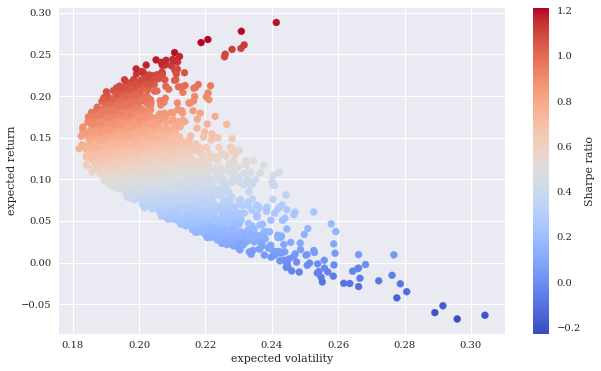

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Cartera eficiente para c=0

Vamos a ver que existe un metodo mediante optimización cuadrática

In [25]:
import scipy.optimize as sco

In [26]:
def min_func_sharpe(weights,rets):
    return -port_ret(weights,rets) / port_vol(weights,rets)

In [27]:
bnds = tuple((0, 1) for x in range(noa))
cons = ({'type': 'eq', 'fun': lambda x:np.sum(x) - 1})
eweights = np.array(noa * [1. / noa,])
eweights

array([0.25, 0.25, 0.25, 0.25])

In [28]:
min_func_sharpe(eweights,rets=rets)

-0.553026890041611

In [29]:
opts = sco.minimize(lambda x : min_func_sharpe(x,rets=rets), eweights, method='SLSQP', bounds=bnds, constraints=cons)
opts

     fun: -1.3238784949621216
     jac: array([1.49011612e-08, 1.02001233e+00, 1.61559328e-01, 9.89519209e-02])
 message: 'Optimization terminated successfully'
    nfev: 10
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1., 0., 0., 0.])

In [30]:
opts['x'].round(3)

array([1., 0., 0., 0.])

In [31]:
rentabilidad = port_ret(opts['x'],rets=rets).round(3)
rentabilidad

0.34

In [32]:
volatilidad = port_vol(opts['x'],rets=rets).round(3)
volatilidad

0.257

In [33]:
sharpe = rentabilidad / volatilidad
sharpe

1.3229571984435797

# Cartera de Mínima Varianza

In [34]:
optv = sco.minimize(lambda x : port_vol(x,rets=rets), eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv

     fun: 0.18137577857357662
     jac: array([0.18111763, 0.23789373, 0.18129035, 0.18144372])
 message: 'Optimization terminated successfully'
    nfev: 50
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([1.24445272e-01, 2.16840434e-18, 1.78390855e-01, 6.97163873e-01])

In [35]:
optv['x'].round(3)

array([0.124, 0.   , 0.178, 0.697])

In [36]:
rentabilidad = port_ret(opts['x'],rets=rets).round(3)
rentabilidad 

0.34

In [37]:
volatilidad = port_vol(opts['x'],rets=rets).round(3)
volatilidad

0.257

In [38]:
sharpe = rentabilidad / volatilidad
sharpe

1.3229571984435797

# Frontera eficiente

In [39]:
cons = ({'type': 'eq', 'fun': lambda x:  port_ret(x,rets=rets) - tret},
                 {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [40]:

trets = np.linspace(0.05, 0.25, 50)
tvols = []
for tret in trets:
    res = sco.minimize(lambda x : port_vol(x,rets=rets), eweights, method='SLSQP',bounds=bnds, constraints=cons)  
    tvols.append(res['fun'])
tvols = np.array(tvols)

In [41]:
print(tvols)

[0.20932004 0.20725763 0.20524057 0.20328157 0.20137745 0.19952978
 0.19774013 0.19601011 0.1943413  0.1927353  0.19119369 0.18971806
 0.18830997 0.18697094 0.18570196 0.18450563 0.18340104 0.18286302
 0.18242028 0.18205501 0.18176766 0.18155862 0.18142815 0.18137642
 0.1814035  0.18150936 0.18169385 0.18195674 0.18229816 0.18271666
 0.18321227 0.18378434 0.18443216 0.18515494 0.18595179 0.18682174
 0.18776423 0.18877734 0.18986038 0.19101209 0.19223155 0.19351702
 0.19486739 0.19628131 0.19775743 0.19929436 0.20089071 0.20254506
 0.20425602 0.20602216]


C:\Users\adriy\AppData\Local\Temp\ipykernel_21200\3846383221.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe ratio')


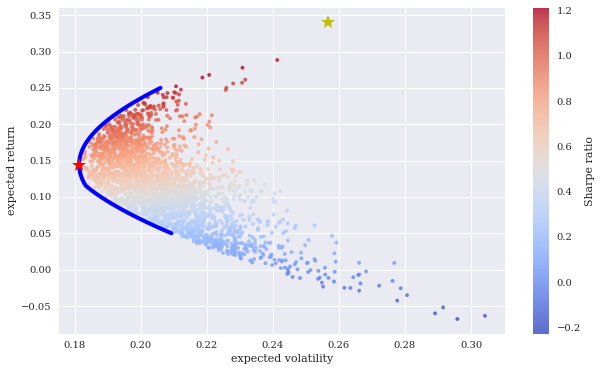

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x'],rets=rets), port_ret(opts['x'],rets=rets),'y*', markersize=15.0)
plt.plot(port_vol(optv['x'],rets=rets), port_ret(optv['x'],rets=rets),'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# Linea del mercado de capitales

In [43]:
import scipy.interpolate as sci

In [44]:
ind = np.argmin(tvols)
print(ind)

23


In [45]:
evols = tvols[ind:]
erets = trets[ind:]

In [46]:
tck = sci.splrep(evols, erets)
tck

(array([0.18137642, 0.18137642, 0.18137642, 0.18137642, 0.18150936,
        0.18169385, 0.18195674, 0.18229816, 0.18271666, 0.18321227,
        0.18378434, 0.18443216, 0.18515494, 0.18595179, 0.18682174,
        0.18776423, 0.18877734, 0.18986038, 0.19101209, 0.19223155,
        0.19351702, 0.19486739, 0.19628131, 0.19775743, 0.19929436,
        0.20089071, 0.20254506, 0.20602216, 0.20602216, 0.20602216,
        0.20602216]),
 array([0.14387755, 0.15222947, 0.15098231, 0.15762446, 0.16038344,
        0.1648135 , 0.16866448, 0.1727523 , 0.17677742, 0.18083545,
        0.18489135, 0.18895374, 0.19302018, 0.1970853 , 0.20115647,
        0.20522696, 0.20930027, 0.21337247, 0.21744735, 0.22152224,
        0.22559792, 0.22967411, 0.23375077, 0.23782786, 0.24335669,
        0.24736158, 0.25      , 0.        , 0.        , 0.        ,
        0.        ]),
 3)

In [47]:
def f(x):
    return sci.splev(x, tck, der=0)
def df(x):
    return sci.splev(x, tck, der=1)

In [48]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]  
    eq2 = rf + p[1] * p[2] - f(p[2])  
    eq3 = p[1] - df(p[2])  
    return eq1, eq2, eq3

In [49]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15]) 

c:\Users\adriy\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [50]:
opt

array([0.01      , 5.66926791, 0.18149767])

C:\Users\adriy\AppData\Local\Temp\ipykernel_21200\246825966.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label='Sharpe ratio')


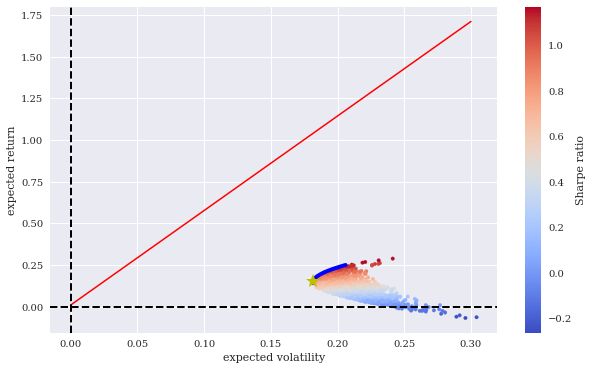

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols,marker='.', cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=4.0)
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')